# Example ODE

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Threshold,PDEFIND
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import TrainTestPeriodic


from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(41)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

Next, we prepare the dataset.

In [2]:
a = 1.
b = 0.1
c = 1.5
d = 0.75
def dU_dt(X, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] -   b*X[0]*X[1] ,
                  -c*X[1] + d*b*X[0]*X[1] ])
t = np.linspace(0, 15,  500)              # time
X0 = np.array([10, 5])                     # initials conditions: 10 rabbits and 5 foxes
Y  = odeint(dU_dt, X0, t)
T = t.reshape(-1,1)

Let's plot it to get an idea of the data:

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [3]:
T_rs = T
Y_rs = Y/np.max(np.abs(Y),axis=0)

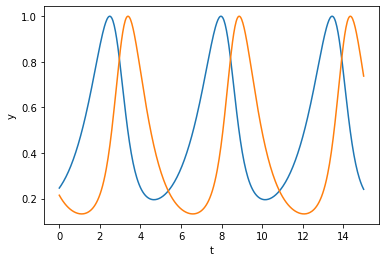

In [4]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,1])
ax.set_xlabel('t')
ax.set_ylabel('y')

plt.show()

In [5]:
number_of_samples = 250

idx = np.random.permutation(Y.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [6]:
print(X_train.shape, y_train.shape)

torch.Size([250, 1]) torch.Size([250, 2])


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [7]:
# Configuration of the function approximator: 
network = NN(1, [50, 50, 50,50], 2)
# Configuration of the function approximator: 
library = Library1D(poly_order=1, diff_order=0) 
# Configuration of the sparsity estimator
estimator = Threshold(0.1) 
# Configuration of the constraint function
constraint = LeastSquares() 
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Now we instantiate the model:

In [8]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [9]:
y_train.shape

torch.Size([250, 2])

In [11]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/lokta_volterra2/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-4
                , patience=8) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
        375      0.38%            1473s   1.70e-06   5.33e-08   1.65e-06   7.71e+00 Algorithm converged. Stopping training.


In [19]:
model.sparsity_masks

[tensor([False, False,  True,  True])]

Now that DeepMoD has converged, it has found the following numbers:

In [11]:
print(model.estimator_coeffs())

[array([[ 0.       ],
       [ 0.       ],
       [ 1.5464184],
       [-1.7551216]], dtype=float32)]


In [14]:
np.max(np.abs(Y),axis=0)

array([40.59793231, 23.27768847])

In [14]:
solution = model(X_train)[0].detach().numpy()

In [16]:
solution.shape

(250, 2)

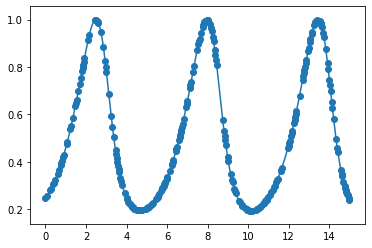

In [17]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,0])
plt.plot(T_rs,Y_rs[:,0])

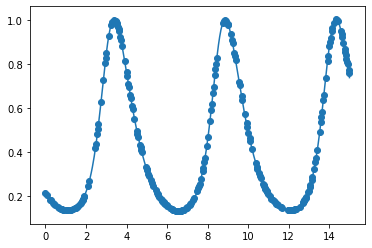

In [18]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,1])
plt.plot(T_rs,Y_rs[:,1])